In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# mother_directory = "/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG1/"
# raw_rg1_clustered = pd.read_csv("/content/drive/MyDrive/MS thesis/preliminary site selection/RG1/rg1-clusters.csv")
# neighbors_df = pd.read_csv(mother_directory + 'Neighbors.csv')
# candidate_sites = pd.read_csv(mother_directory + "candidate_sites.csv")
# results = pd.read_csv(mother_directory + "results.csv")

# '''AGGREGATING THE POPULATION'''
# # # Assuming df is your DataFrame
# # vp =  raw_rg1_clustered['popden_chi'] + raw_rg1_clustered['popden_eld'] + raw_rg1_clustered['popden_wom'] + raw_rg1_clustered['popden_you'] + raw_rg1_clustered['popden_w_1'] + raw_rg1_clustered['popden_you']
# # gen = raw_rg1_clustered['popden_all'] - vp
# # all = vp + gen
# # raw_rg1_clustered['total_population'] = all
# # raw_rg1_clustered.columns

# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['Unnamed: 0'])
# neighbors_df.rename(columns={'fid': 'ID'}, inplace=True)
# print(raw_rg1_clustered.columns)
# print(neighbors_df.columns)

region = 1
mother_directory = f"/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}/"
# raw_rg1_clustered = pd.read_csv("/content/drive/MyDrive/MS thesis/preliminary site selection/CALABARZON/calabarzon_clusters.csv")
raw_rg1_clustered = pd.read_csv("/content/drive/MyDrive/MS thesis/preliminary site selection/RG1/rg1-clusters.csv")

# raw_rg1_clustered = pd.read_csv(mother_directory + "PCF_data.csv")
# use pcf data nalang para you dont get nans for sure?

neighbors_df = pd.read_csv(mother_directory + 'Neighbors.csv')
candidate_sites = pd.read_csv(mother_directory + "candidate_sites.csv")

raw_rg1_clustered = raw_rg1_clustered.drop(columns=['Unnamed: 0'])
print(raw_rg1_clustered.columns)
neighbors_df.rename(columns={'fid': 'ID'}, inplace=True)
# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['HCFAI.1'])
raw_rg1_clustered = raw_rg1_clustered.drop(columns=['Neighbors'])
raw_rg1_clustered = raw_rg1_clustered[raw_rg1_clustered['Cluster'] == 0]

Index(['ID', 'barangay_name', 'city_name', 'province_name', 'popden_chi',
       'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1', 'popden_all',
       'flood_probability_value', 'rain intensity_value', 'drought_value',
       'buildability_landcov', 'RHU_Presence', 'Road_Presence', 'POI_Presence',
       'Nearest_RHU', 'Distance_to_Nearest_RHU_km', 'Neighbors', 'HCFAI',
       'Cluster'],
      dtype='object')


In [3]:
def HCI_calc(total_ai, total_gi, total_hi, total_ji, total_ki, total_mi, distance, road_bi, POI_ci, landCov_di, hazard1_ei, hazard2_ei, hazard3_ei, rhus_fi):
    total_vulnerable = total_gi + total_hi + total_ji + total_ki + total_mi
    total_pop = total_ai
    population_to_be_served = total_vulnerable + np.maximum(0, total_pop - total_vulnerable)
    y = np.where(population_to_be_served == 0, 0, 20000 / ((population_to_be_served) * (distance + rhus_fi)))
    mc = np.tanh(y)
    w_bi = 0.3  # roads
    w_ci = 0.2  # POIs
    w_di = 0.5  # land cov
    b = (POI_ci * w_ci) + (road_bi * w_bi) + (landCov_di * w_di)
    rain_intensity_normalized = (hazard1_ei - hazard1_ei.min()) / (hazard1_ei.max() - hazard1_ei.min())
    flood_probability_normalized = (hazard2_ei - hazard2_ei.min()) / (hazard2_ei.max() - hazard2_ei.min())
    drought_mean_normalized = (hazard3_ei - hazard3_ei.min()) / (hazard3_ei.max() - hazard3_ei.min())
    w_rain = 0.4
    w_flood = 0.3
    w_drought = 0.3
    c = (w_rain * rain_intensity_normalized) + (w_flood * flood_probability_normalized) + (w_drought * drought_mean_normalized)
    f = b - c
    f = np.tanh(f)
    hci = mc * f
    hcfai = (1 + np.tanh(hci / 2)) / 2  # Sigmoid function

    return hcfai

def overallHCFAI(region_df):
    if 'HCFAI' in region_df.columns:
        HCFAI_overall = region_df['HCFAI'].sum()
    elif 'new HCFAI' in region_df.columns:
        HCFAI_overall = region_df['new HCFAI'].sum()
    return HCFAI_overall

def selectTopSites(candidate_sites, region_df, selected_sites, n):
    if len(selected_sites) < n:  # if optimal and existing RHUs list is incomplete
        while len(selected_sites) < n:
            new_site = candidate_sites.iloc[:1].copy()
            selected_sites = pd.concat([selected_sites, new_site], ignore_index=True)
            candidate_sites = candidate_sites.drop(candidate_sites.index[0]).reset_index(drop=True)

    # region_df = region_df.drop('total_population', axis=1)

    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km']

    merged_sites = candidate_sites.merge(region_df[columns_to_merge], on='ID', how='left')
    merged_sites['HCFAI'] = HCI_calc(merged_sites['popden_all'],
                                     merged_sites['popden_chi'],
                                     merged_sites['popden_eld'],
                                     merged_sites['popden_wom'],
                                     merged_sites['popden_you'],
                                     merged_sites['popden_w_1'],
                                     merged_sites['Distance_to_Nearest_RHU_km'],
                                     merged_sites['Road_Presence'],
                                     merged_sites['POI_Presence'],
                                     merged_sites['buildability_landcov'],
                                     merged_sites['rain intensity_value'],
                                     merged_sites['flood_probability_value'],
                                     merged_sites['drought_value'],
                                     merged_sites['RHU_Presence'],
                                     )

    missing_cols = [col for col in region_df.columns if col != 'ID']
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])

    top_sites = merged_sites.sort_values(by='HCFAI', ascending=False).head(n)
    return top_sites

def removeAdjacentSites(region_df, candidate_sites, selected_sites, neighbors_df, n):
    idx_with_RHU = region_df[region_df['RHU_Presence'] == 1]
    adjacent_sites = set()
    with_RHU_indices = selected_sites['ID'].tolist()
    for site_id in selected_sites['ID']:
        if site_id in neighbors_df['ID'].values:
            neighbors = neighbors_df.loc[neighbors_df['ID'] == site_id, 'Neighbors'].iloc[0]
            adjacent_sites.update(neighbors.split(','))
    adjacent_sites.update(idx_with_RHU['ID'])
    adjacent_sites.update(selected_sites['ID'])
    adjacent_sites = [int(site) for site in adjacent_sites]
    candidate_sites = candidate_sites[~candidate_sites['ID'].isin(adjacent_sites)].reset_index(drop=True)

    print(f"{len(candidate_sites)} Candidate sites left")
    print(f"This is what we'll put on QGIS: {selected_sites['ID'].tolist()}")

    if len(candidate_sites) > n:
      for i in with_RHU_indices:
          print(f"Site {i} has the following sites to choose from: {candidate_sites['ID'].tolist()}")
          if i in adjacent_sites:
              print(f"Site {i} was highkey sus for not saying they have neighbors ...")
              with_RHU_indices.remove(i)
              selected_sites = selected_sites.drop(selected_sites[selected_sites['ID'] == i].index).reset_index(drop=True)
    elif len(candidate_sites) <= n:
      return candidate_sites, selected_sites, idx_with_RHU

    selected_sites['HCFAI'] = HCI_calc(selected_sites['popden_all'], selected_sites['popden_chi'],
                                       selected_sites['popden_eld'], selected_sites['popden_wom'],
                                       selected_sites['popden_you'], selected_sites['popden_w_1'],
                                       selected_sites['Distance_to_Nearest_RHU_km'],
                                       selected_sites['Road_Presence'], selected_sites['POI_Presence'],
                                       selected_sites['buildability_landcov'], selected_sites['rain intensity_value'],
                                       selected_sites['flood_probability_value'], selected_sites['drought_value'],
                                       selected_sites['RHU_Presence'])
    return candidate_sites, selected_sites, idx_with_RHU

def optimize(region_df, candidate_sites, neighbors_df, num_facilities):
    original_HCFAI = overallHCFAI(region_df)
    print("Original HCFAI:", original_HCFAI)
    print(region_df.columns)
    region_df = region_df.drop(['barangay_name', 'city_name', 'province_name'], axis=1)


    selected_sites = pd.DataFrame(columns=region_df.columns)
    top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))


    while len(selected_sites) < num_facilities:
        # candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        if len(candidate_sites) <= num_facilities:
          top_sites = candidate_sites
        elif len(candidate_sites) > num_facilities:
          top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))
          selected_sites = top_sites

        candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        selected_sites = pd.concat([selected_sites, top_sites]).reset_index(drop=True)
        remaining_sites = region_df[~region_df['ID'].isin(selected_sites['ID'])]
        remaining_HCFAI = overallHCFAI(remaining_sites)
        selected_sites_HCFAI = overallHCFAI(selected_sites)
        updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
        print("Updated HCFAI:", updated_HCFAI)
        print(f"{len(selected_sites)} selected sites")

        if len(selected_sites) == num_facilities:
            print("Accept!!!!!!!!!!!!!!")
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        elif len(candidate_sites) <= num_facilities:
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        else:
            print("Reject!!!!!!!!!!!!!!")
            print("Selected sites:", len(selected_sites))
            top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

    return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

In [4]:
# Optimize selection of health facility sites
pcf = 345
selected_facilities, hex_with_RHU, og_HCFAI, updated_HCFAI = optimize(raw_rg1_clustered, candidate_sites, neighbors_df, pcf) # 48
selected_facilities = list(selected_facilities['ID'])
hex_with_RHU = list(hex_with_RHU['ID'])
# selected_facilities
hex_with_RHU

Original HCFAI: 1544.51758599
Index(['ID', 'barangay_name', 'city_name', 'province_name', 'popden_chi',
       'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1', 'popden_all',
       'flood_probability_value', 'rain intensity_value', 'drought_value',
       'buildability_landcov', 'RHU_Presence', 'Road_Presence', 'POI_Presence',
       'Nearest_RHU', 'Distance_to_Nearest_RHU_km', 'HCFAI', 'Cluster'],
      dtype='object')
1196 Candidate sites left
This is what we'll put on QGIS: [2915186, 2912423, 2913805, 2916568, 2946847, 2945463, 2946846, 2944083, 2945464, 2944082, 2942762, 2949623, 2948226, 2946844, 2946845, 2945462, 2942698, 2944081, 2944080, 2945461, 2948211, 2985660, 2902737, 2899974, 2905500, 2904118, 2906881, 2917950, 2901356, 2942697, 2941316, 2908265, 2909647, 2945458, 2946841, 2948223, 2959387, 2960769, 2963533, 2960770, 2959388, 2937194, 2963475, 2944136, 2960771, 2963534, 2953768, 2952386, 2952388, 2969064, 2981515, 2904122, 2904123, 2905504, 2905505, 2902741, 290688

[2880597,
 2919329,
 2928944,
 2928986,
 2930381,
 2933032,
 2933033,
 2933148,
 2934515,
 2934525,
 2939923,
 2939928,
 2941335,
 2941443,
 2950966,
 2953720,
 2953721,
 2953722,
 2956475,
 2959251,
 2960650,
 2960778,
 2971664,
 2977219]

In [5]:
list(set(selected_facilities))


print(f"Optimal sites: {len(set(selected_facilities))}")
print(f"{list(set(selected_facilities))}")
print(f"Sites with RHUs: {len(hex_with_RHU)}")
print(f"{hex_with_RHU}")
print(f"Candidate sites: {len(candidate_sites)}")
print(f"{list(candidate_sites['ID'])}")

Optimal sites: 345
[2899968, 2899969, 2899970, 2899974, 2899975, 2963475, 2959387, 2959388, 2904111, 2904118, 2904119, 2904120, 2904121, 2904122, 2904123, 2904126, 2904127, 2967622, 2963533, 2963534, 2963550, 2908264, 2908265, 2908266, 2908267, 2908268, 2908269, 2908271, 2908272, 2908273, 2908274, 2908275, 2908276, 2967681, 2912415, 2912416, 2912417, 2912418, 2912419, 2912420, 2912423, 2916564, 2916565, 2916568, 2988255, 2988256, 2988257, 2988259, 2928883, 2975988, 2975989, 2992397, 2980135, 2933032, 2924866, 2933091, 2933096, 2933097, 2937194, 2933099, 2933098, 2933100, 2941314, 2941315, 2941316, 2937226, 2937227, 2941324, 2941325, 2937232, 2941335, 2945440, 2945456, 2945457, 2945458, 2937264, 2937265, 2945461, 2945462, 2945463, 2945464, 2941372, 2945475, 2949593, 2941406, 2949603, 2949604, 2949605, 2953700, 2941412, 2941426, 2949622, 2949623, 2949627, 2949628, 2941443, 2953738, 2949647, 2957848, 2953768, 2962005, 2962006, 2962007, 2962008, 2962013, 2894441, 2894442, 2894443, 2894444,

# Validation

In [6]:
import random
import pandas as pd

def getRandom48(candidate_sites, random_seed=None):
    """
    Randomly select 48 sites from the candidate sites DataFrame.

    Parameters:
        candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: Randomly selected 48 sites DataFrame.
    """
    if random_seed is not None:
        random.seed(random_seed)
    candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
    random_48 = candidate_sites_shuffled.sample(n=pcf)
    return random_48


def randomize(region_df, candidate_sites, random_seed):
    """
    Randomize the selection of 48 sites and update the overall HCFAI value.
    Parameters:
        region_df (DataFrame): DataFrame containing information about all sites in the region.
    Returns:
        tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
    """
    HCFAI_overall_before = overallHCFAI(region_df)
    # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
    random_48 = getRandom48(candidate_sites, random_seed)
    columns_to_merge = ['ID', 'barangay_name', 'city_name', 'province_name',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km', 'HCFAI']
    merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
    missing_cols = [col for col in region_df.columns if col != ['ID']]
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])
    # Calculate HCFAI for the remaining sites in region_df
    remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
    remaining_HCFAI = overallHCFAI(remaining_sites)
    print(remaining_HCFAI)
    selected_sites_HCFAI = overallHCFAI(merged_sites)
    print(selected_sites_HCFAI)

    # Calculate updated overall HCFAI
    updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
    # print(f"Updated HCFAI: ", updated_HCFAI)
    return updated_HCFAI, random_48['ID'].tolist()

# Example usage
rdm_hcfai = []
rdm_points = []
for i in range(10):
    random_seed = i  # Use a different random seed for each iteration
    rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
    rdm_hcfai.append(rdm_ovHCFAI)
    rdm_points.append(rdm_48)

rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
highest_rdm_HCFAI = max(rdm_hcfai)
# print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

Results_rdmsum = pd.DataFrame({
    'Hex IDs': rdm_points,
    'HCFAI': rdm_hcfai
})

print("=========== OG HCFAI RESULTS ===========")
print("ORIGINAL HCFAI", og_HCFAI)
print("=========== RANDOM HCFAI RESULTS ===========")
# print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
print("RANDOMIZED HCFAI [10-fold]: ", highest_rdm_HCFAI)
# print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
print("=========== OPTIMIZED HCFAI RESULTS ===========")
print("OPTIMIZED HCFAI ", updated_HCFAI)

1382.95907648
161.55850951000002
1381.3738670499997
163.14371893999999
1382.82058649
161.6969995
1381.7416286400003
162.77595735
1382.6081434100001
161.90944258
1381.89524948
162.62233651000003
1381.66332877
162.85425722000002
1381.9397433600002
162.57784263000002
1382.9998498
161.51773619
1381.4773471600001
163.04023883000002
=========== OG HCFAI RESULTS ===========
ORIGINAL HCFAI 1544.51758599
=========== RANDOM HCFAI RESULTS ===========
RANDOMIZED HCFAI [10-fold]:  1544.5175859900003
=========== OPTIMIZED HCFAI RESULTS ===========
OPTIMIZED HCFAI  1639.1095106117184


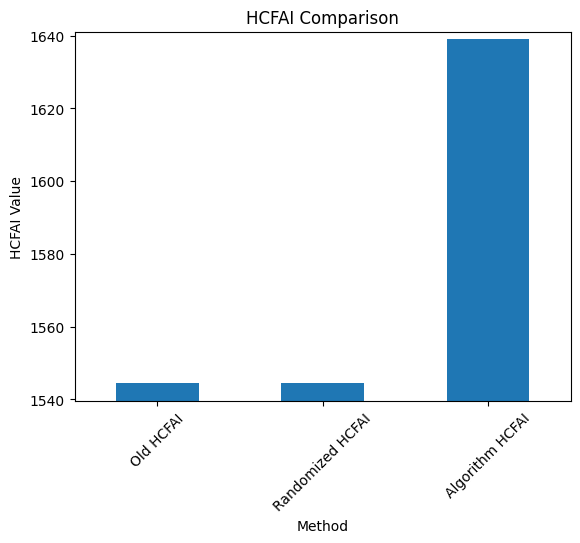

In [7]:
hcfai_compare_df =  pd.DataFrame(
    {' ': ['SUM'],
    'Old HCFAI': og_HCFAI,
     'Randomized HCFAI': highest_rdm_HCFAI,
     'Algorithm HCFAI': updated_HCFAI
    })

import matplotlib.pyplot as plt
# Preparing the data for plotting
# Since we have only one row with label 'SUM', we'll use it as index
hcfai_compare_df.set_index(' ', inplace=True)
hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# Plotting the bar chart
hcfai_compare_df.plot(kind='bar', legend=False)
plt.title('HCFAI Comparison')
plt.ylabel('HCFAI Value')
plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.show()